# Business Analytics (A)
### Pricing NBA Arena Seats Data Sources: Secondary Market Ticket Sales 
### Focus areas: Supervised ML, Ticket Pricing, Presentation and Communication

§ Each NBA team has to price thousands of single game tickets for 41 home games and then update the price in real time to align with the secondary market.

§ Given anonymized historical ticket prices, matchup info and seat location calculate a seat quality score.

§ Use the seat quality score and given market data to assign the optimal ticket price to unsold inventory.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from bokeh.plotting import figure, save
from bokeh.models import ColumnDataSource
from pandas_profiling import ProfileReport

/var/folders/1p/n1yg43r91032z6dwjfvfltz00000gn/T/ipykernel_62096/4067597720.py:10: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [5]:
listing = pd.read_csv("2024-03-06 Listing Data.csv")
location = pd.read_csv("2024-03-06 Seat Coordinates.csv")

In [6]:
#import game data & combine dataframes
date_team_win_percent_df = pd.read_csv("win_percentages.csv")

In [7]:
#merge dataframes
merged_df = pd.merge(listing, location[['SECTION_ROW_SEAT_NAME', 'SEAT_CENTER_X', 'SEAT_CENTER_Y']], on=['SECTION_ROW_SEAT_NAME'], how='left')

In [8]:
# Merge the DataFrames based on matching dates and visitor team tri codes
final_df = pd.merge(merged_df, date_team_win_percent_df, how='left', left_on=['GAME_DATE', 'VISITOR_TEAM_TRI_CODE'], right_on=['Date', 'Visitor_Team'])

In [9]:
final_df.head()

,GAME_ID,GAME_DATE,GAME_TIME,SEASON_ID,SEASON_STAGE,VISITOR_TEAM_TRI_CODE,HOME_TEAM_TRI_CODE,SECTION_CATEGORY,SECTION_GROUP,SECTION_LEVEL,...,TICKET_LISTING_PRICE,DAYS_INVENTORY_LEAD_TIME,INVENTORY_LEAD_TIME_CATEGORY,SEAT_CENTER_X,SEAT_CENTER_Y,Date,Home_Team,Home_Win_Percentage,Visitor_Team,Visitor_Win_Percentage
0,22200002,2022-10-18,19:00:00,2022,REGULAR SEASON,LAL,GSW,PREMIUM,LOWER BOWL,LEVEL 100,...,613.0,0.0,EVENT DAY,2674.0,3604.0,2022-10-18,GSW,1.0,LAL,0.0
1,22200002,2022-10-18,19:00:00,2022,REGULAR SEASON,LAL,GSW,PREMIUM,LOWER BOWL,LEVEL 100,...,480.0,0.0,EVENT DAY,1366.0,3577.0,2022-10-18,GSW,1.0,LAL,0.0
2,22200002,2022-10-18,19:00:00,2022,REGULAR SEASON,LAL,GSW,PREMIUM,LOWER BOWL,LEVEL 100,...,470.0,0.0,EVENT DAY,1446.0,3436.0,2022-10-18,GSW,1.0,LAL,0.0
3,22200002,2022-10-18,19:00:00,2022,REGULAR SEASON,LAL,GSW,PREMIUM,LOWER BOWL,LEVEL 100,...,595.0,0.0,EVENT DAY,2962.0,1522.0,2022-10-18,GSW,1.0,LAL,0.0
4,22200002,2022-10-18,19:00:00,2022,REGULAR SEASON,LAL,GSW,NON-PREMIUM,UPPER BOWL,LEVEL 200,...,300.0,0.0,EVENT DAY,2146.0,548.0,2022-10-18,GSW,1.0,LAL,0.0


In [10]:
final_df.describe()

,GAME_ID,SEASON_ID,TICKET_LISTING_PRICE,DAYS_INVENTORY_LEAD_TIME,SEAT_CENTER_X,SEAT_CENTER_Y,Home_Win_Percentage,Visitor_Win_Percentage
count,4.593060e+05,459306.000000,459306.000000,459306.000000,454176.000000,454176.000000,459306.000000,459306.000000
mean,2.224909e+07,2022.485030,257.113451,17.844827,2516.775862,2527.398762,0.504525,0.489742
std,4.994901e+04,0.499776,336.246032,25.552107,1060.601536,1180.165152,0.089911,0.177255
min,2.220000e+07,2022.000000,0.000000,0.000000,134.000000,544.000000,0.000000,0.000000
25%,2.220057e+07,2022.000000,106.000000,0.000000,1590.000000,1524.000000,0.474000,0.409000
50%,2.220116e+07,2022.000000,169.000000,6.000000,2530.000000,2604.000000,0.508000,0.500000
75%,2.230050e+07,2023.000000,290.000000,25.000000,3426.000000,3499.000000,0.522000,0.603000
max,2.230121e+07,2023.000000,20000.000000,120.000000,4562.000000,4456.000000,1.000000,1.000000


In [11]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459306 entries, 0 to 459305
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   GAME_ID                       459306 non-null  int64  
 1   GAME_DATE                     459306 non-null  object 
 2   GAME_TIME                     459306 non-null  object 
 3   SEASON_ID                     459306 non-null  int64  
 4   SEASON_STAGE                  459306 non-null  object 
 5   VISITOR_TEAM_TRI_CODE         459306 non-null  object 
 6   HOME_TEAM_TRI_CODE            459306 non-null  object 
 7   SECTION_CATEGORY              459210 non-null  object 
 8   SECTION_GROUP                 459306 non-null  object 
 9   SECTION_LEVEL                 459306 non-null  object 
 10  SECTION_NAME                  459306 non-null  object 
 11  ROW_NAME                      459306 non-null  object 
 12  SEAT_NAME                     459306 non-nul

In [12]:
final_df['GAME_DATE'] = pd.to_datetime(final_df['GAME_DATE'])
final_df['GAME_TIME'] = pd.to_datetime(final_df['GAME_TIME'])
final_df['SEASON_STAGE'] = final_df['SEASON_STAGE'].astype('category').cat.codes
final_df['VISITOR_TEAM_TRI_CODE']= final_df['VISITOR_TEAM_TRI_CODE'].astype('category').cat.codes
final_df['HOME_TEAM_TRI_CODE']= final_df['HOME_TEAM_TRI_CODE'].astype('category').cat.codes
final_df['SECTION_CATEGORY']= final_df['SECTION_CATEGORY'].astype('category').cat.codes
final_df['SECTION_GROUP']= final_df['SECTION_GROUP'].astype('category').cat.codes
final_df['SECTION_LEVEL']= final_df['SECTION_LEVEL'].astype('category').cat.codes
final_df['SECTION_NAME']= final_df['SECTION_NAME'].astype('category').cat.codes
final_df['ROW_NAME']= final_df['ROW_NAME'].astype('category').cat.codes
final_df['SEAT_NAME']= final_df['SEAT_NAME'].astype('category').cat.codes
final_df['INVENTORY_LEAD_TIME_CATEGORY']= final_df['INVENTORY_LEAD_TIME_CATEGORY'].astype('category').cat.codes

/var/folders/1p/n1yg43r91032z6dwjfvfltz00000gn/T/ipykernel_62096/1644489463.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  final_df['GAME_TIME'] = pd.to_datetime(final_df['GAME_TIME'])


In [13]:
profile = ProfileReport(final_df, 
                        title='Pandas Profiling Report',
                        html={'style':{'full_width':True}},
                       minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
final_df.isna().sum()

GAME_ID                            0
GAME_DATE                          0
GAME_TIME                          0
SEASON_ID                          0
SEASON_STAGE                       0
VISITOR_TEAM_TRI_CODE              0
HOME_TEAM_TRI_CODE                 0
SECTION_CATEGORY                   0
SECTION_GROUP                      0
SECTION_LEVEL                      0
SECTION_NAME                       0
ROW_NAME                           0
SEAT_NAME                          0
SECTION_ROW_SEAT_NAME              0
TICKET_LISTING_PRICE               0
DAYS_INVENTORY_LEAD_TIME           0
INVENTORY_LEAD_TIME_CATEGORY       0
SEAT_CENTER_X                   5130
SEAT_CENTER_Y                   5130
Date                               0
Home_Team                          0
Home_Win_Percentage                0
Visitor_Team                       0
Visitor_Win_Percentage             0
dtype: int64

In [15]:
 %matplotlib inline 

Text(0, 0.5, 'Frequency')

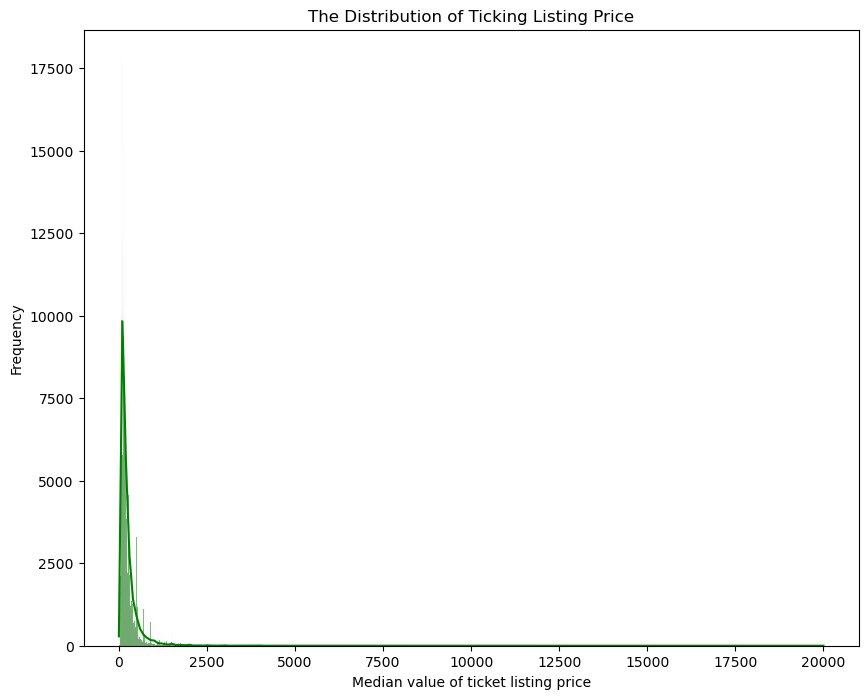

In [16]:
plt.figure(figsize=(10,8))
sns.histplot(final_df["TICKET_LISTING_PRICE"], kde=True,color="green")
plt.title("The Distribution of Ticking Listing Price")
plt.xlabel("Median value of ticket listing price")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

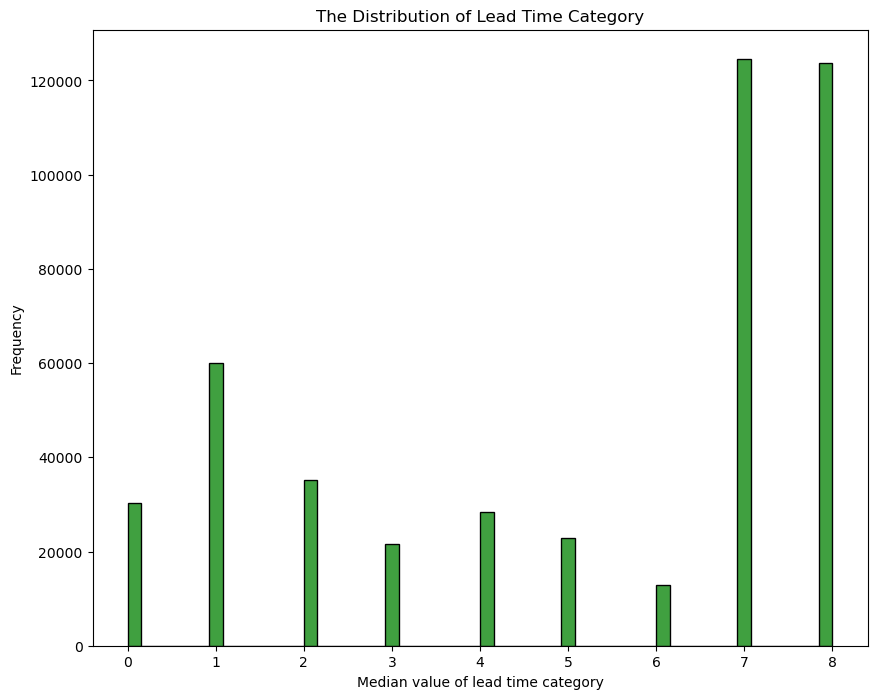

In [17]:
plt.figure(figsize=(10,8))
sns.histplot(final_df["INVENTORY_LEAD_TIME_CATEGORY"],color="green")
plt.title("The Distribution of Lead Time Category")
plt.xlabel("Median value of lead time category")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

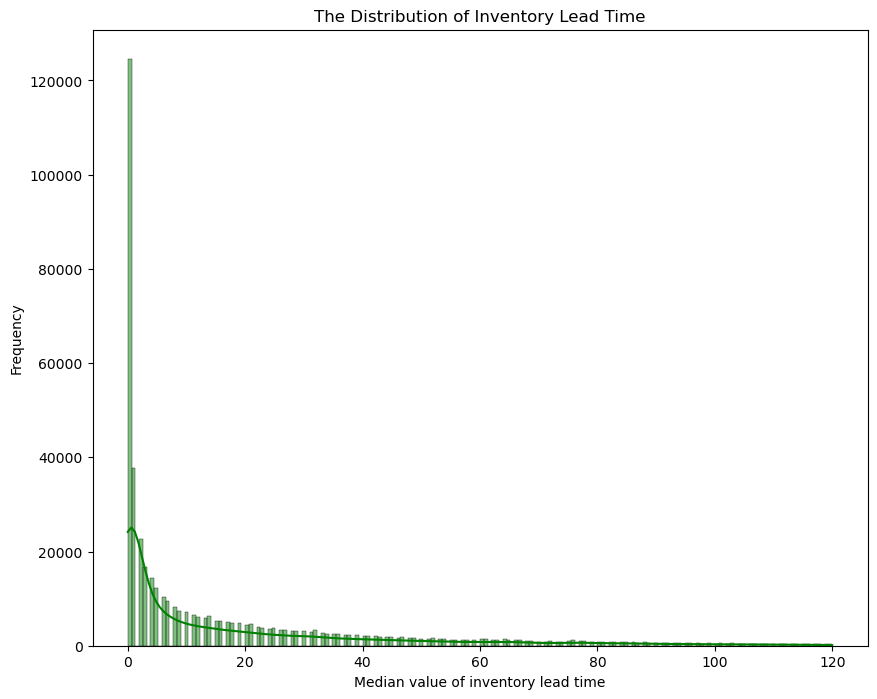

In [18]:
plt.figure(figsize=(10,8))
sns.histplot(final_df["DAYS_INVENTORY_LEAD_TIME"], kde=True,color="green")
plt.title("The Distribution of Inventory Lead Time")
plt.xlabel("Median value of inventory lead time")
plt.ylabel("Frequency")

Text(0.5, 1.0, 'The Distribution of Ticket Listing Price')

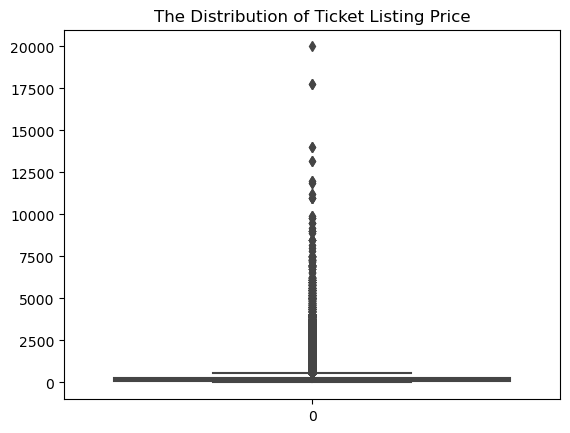

In [19]:
sns.boxplot(final_df["TICKET_LISTING_PRICE"], palette="rocket")
plt.title ("The Distribution of Ticket Listing Price")

In [20]:
final_df["TICKET_LISTING_PRICE"].describe()

count    459306.000000
mean        257.113451
std         336.246032
min           0.000000
25%         106.000000
50%         169.000000
75%         290.000000
max       20000.000000
Name: TICKET_LISTING_PRICE, dtype: float64

Notably, the max value of $20,000 is an outlier in the ticket listing price. The question is whether this is a valid ticket price, or whether it is an error in data collection. Either way, it should likely be removed from the model calculation, as it is a single ticket value? 

In [21]:
#dropping outlier
finaldf = final_df[final_df.TICKET_LISTING_PRICE != 20000]

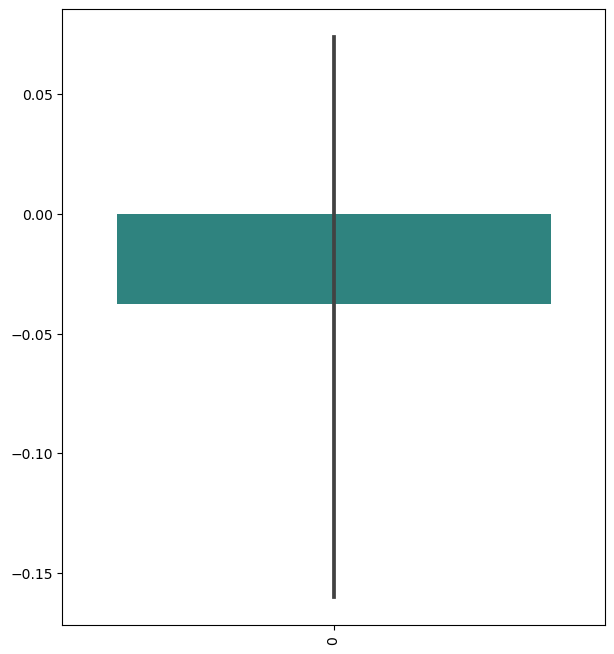

SECTION_GROUP                  -0.629019
SECTION_LEVEL                  -0.437628
SECTION_NAME                   -0.108443
INVENTORY_LEAD_TIME_CATEGORY   -0.069599
VISITOR_TEAM_TRI_CODE          -0.035487
SEAT_CENTER_X                  -0.023090
SEASON_ID                      -0.018887
GAME_ID                        -0.018882
SEAT_CENTER_Y                  -0.011094
SEAT_NAME                       0.025996
Home_Win_Percentage             0.033482
Visitor_Win_Percentage          0.040913
DAYS_INVENTORY_LEAD_TIME        0.086398
ROW_NAME                        0.232900
SECTION_CATEGORY                0.367028
SEASON_STAGE                         NaN
HOME_TEAM_TRI_CODE                   NaN
Name: TICKET_LISTING_PRICE, dtype: float64


In [22]:
correlated = final_df.corr(numeric_only=True) ["TICKET_LISTING_PRICE"]. sort_values().drop(index="TICKET_LISTING_PRICE")
plt.figure(figsize=(7,8), dpi=100)
sns.barplot(data=correlated,palette="viridis")
plt.xticks(rotation=90)
plt.show()
print(correlated)

### Graph of the average price of each section of seats over time

In [23]:
section_price = final_df.groupby('SECTION_NAME')['TICKET_LISTING_PRICE'].mean()

In [24]:
section_price = final_df.groupby(['SECTION_NAME', 'DAYS_INVENTORY_LEAD_TIME']).TICKET_LISTING_PRICE.mean()

In [25]:
section_price

SECTION_NAME  DAYS_INVENTORY_LEAD_TIME
0             0.0                           172.4
              1.0                           251.0
              2.0                           161.2
              3.0                           131.0
              4.0                           149.5
                                           ...   
76            97.0                         1600.0
              104.0                        6000.0
              112.0                        2002.0
              117.0                       17777.0
              119.0                        6000.0
Name: TICKET_LISTING_PRICE, Length: 7202, dtype: float64

In [26]:
section_price = section_price.unstack(level='SECTION_NAME')

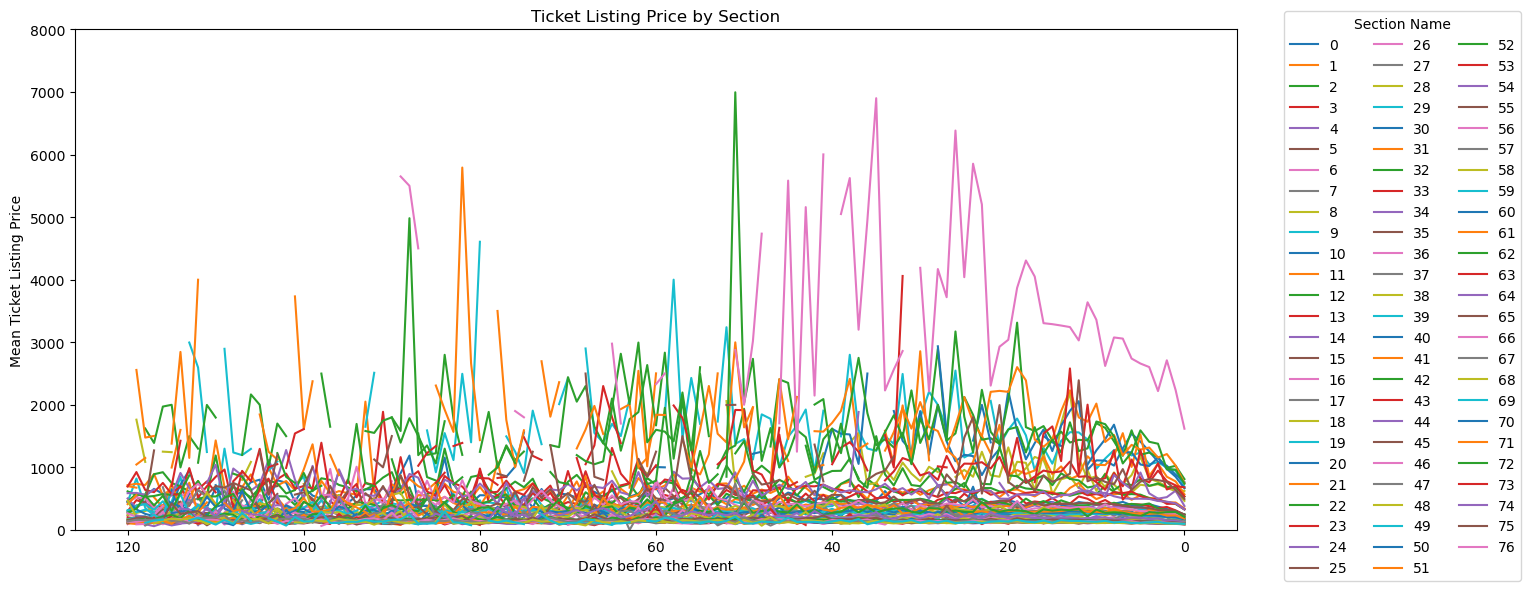

In [27]:
fig, ax = plt.subplots(figsize=(15, 6.5))
ax.plot(section_price)

ax.set_xlabel('Days before the Event')
ax.set_ylabel('Mean Ticket Listing Price')
ax.set_ylim([0, 8000])
ax.invert_xaxis()
plt.title('Ticket Listing Price by Section')

ax.legend(section_price.columns, title="Section Name", loc='upper right', bbox_to_anchor=(1.25, 1.05), ncol=3)

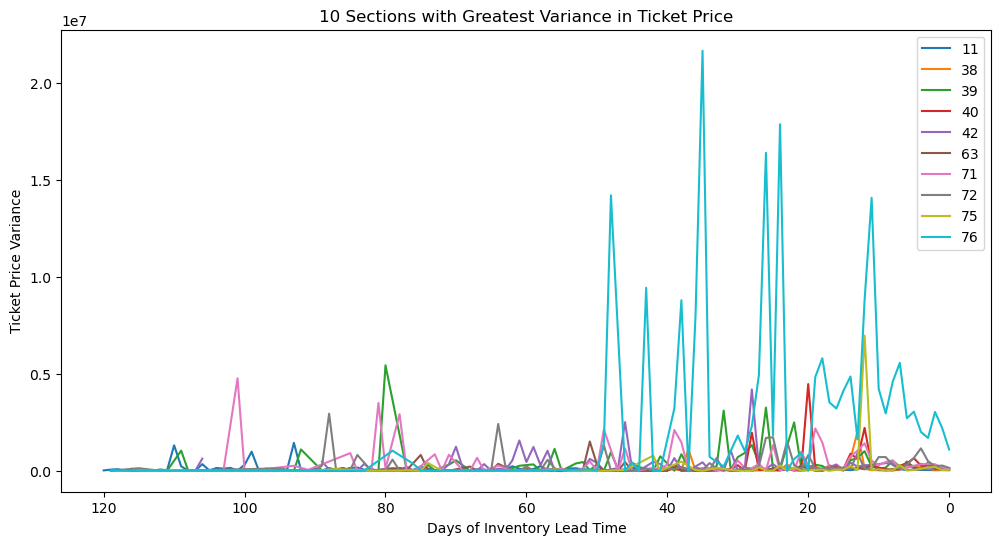

In [28]:
variance_df = final_df.groupby(['SECTION_NAME', 'DAYS_INVENTORY_LEAD_TIME'])['TICKET_LISTING_PRICE'].var().reset_index()

sorted_sections = variance_df.groupby('SECTION_NAME')['TICKET_LISTING_PRICE'].mean().sort_values(ascending=False)

top_sections = sorted_sections.head(10).index

top_df = variance_df[variance_df['SECTION_NAME'].isin(top_sections)]

plt.figure(figsize=(12, 6))
for section, data in top_df.groupby('SECTION_NAME'):
    plt.plot(data['DAYS_INVENTORY_LEAD_TIME'], data['TICKET_LISTING_PRICE'], label=section)

plt.xlabel('Days of Inventory Lead Time')
plt.ylabel('Ticket Price Variance')
plt.gca().invert_xaxis()
plt.title('10 Sections with Greatest Variance in Ticket Price')
plt.legend()
plt.show()

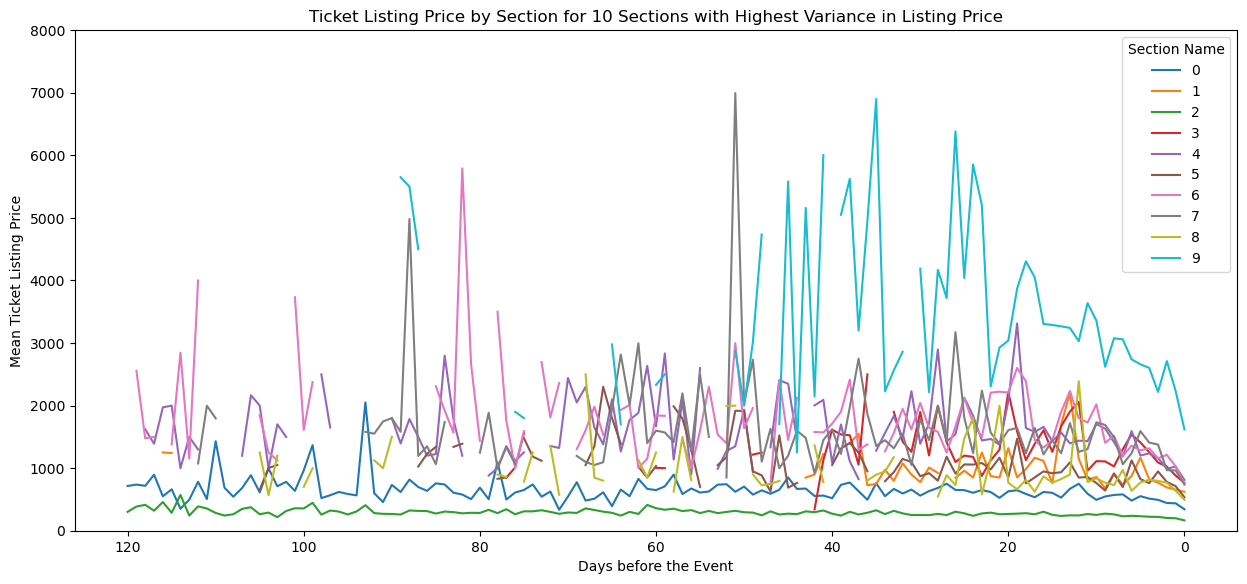

In [29]:
top_variance = section_price[[11, 38, 29, 40, 42, 63, 71, 72, 75, 76]]

fig, ax = plt.subplots(figsize=(15, 6.5))
ax.plot(top_variance)

ax.set_xlabel('Days before the Event')
ax.set_ylabel('Mean Ticket Listing Price')
ax.set_ylim([0, 8000])
ax.invert_xaxis()
plt.title('Ticket Listing Price by Section for 10 Sections with Highest Variance in Listing Price')

ax.legend(section_price.columns, title="Section Name", loc='upper right', bbox_to_anchor=(1, 1), ncol=1)

### Linear Regression Model

In [30]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [31]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459306 entries, 0 to 459305
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   GAME_ID                       459306 non-null  int64         
 1   GAME_DATE                     459306 non-null  datetime64[ns]
 2   GAME_TIME                     459306 non-null  datetime64[ns]
 3   SEASON_ID                     459306 non-null  int64         
 4   SEASON_STAGE                  459306 non-null  int8          
 5   VISITOR_TEAM_TRI_CODE         459306 non-null  int8          
 6   HOME_TEAM_TRI_CODE            459306 non-null  int8          
 7   SECTION_CATEGORY              459306 non-null  int8          
 8   SECTION_GROUP                 459306 non-null  int8          
 9   SECTION_LEVEL                 459306 non-null  int8          
 10  SECTION_NAME                  459306 non-null  int8          
 11  ROW_NAME     

In [32]:
#drop date/time variables and "duplicate" variables
X = final_df.drop(["TICKET_LISTING_PRICE", 'SECTION_ROW_SEAT_NAME', 'GAME_DATE',
                   'GAME_TIME', 'GAME_ID', 'SEASON_ID', 'HOME_TEAM_TRI_CODE', 'SECTION_GROUP',
                  'SECTION_LEVEL', 'SECTION_NAME', 'ROW_NAME', 'SEAT_NAME', 'SECTION_ROW_SEAT_NAME', 'DAYS_INVENTORY_LEAD_TIME',
                  'SEAT_CENTER_X', 'SEAT_CENTER_Y', 'Date', 'Home_Team', 'Visitor_Team'], axis=1)
y = final_df["TICKET_LISTING_PRICE"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [33]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(X_train,y_train)

LinearRegression()

In [34]:
y_pred = LR.predict(X_test)
y_pred

array([128.29876611, 390.26602732, 150.92022763, ..., 227.14195305,
       200.27347544, 141.41464912])

In [35]:
# Access the coefficients (weights) of the model
coefficients = LR.coef_

# Match coefficients with feature names
feature_names = X.columns

# Print the coefficient for each feature
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef}")

SEASON_STAGE: 0.0
VISITOR_TEAM_TRI_CODE: -0.9491510045678488
SECTION_CATEGORY: 252.11495567444666
INVENTORY_LEAD_TIME_CATEGORY: -11.029779642274608
Home_Win_Percentage: 234.35017058896597
Visitor_Win_Percentage: 123.89297118954201


In [36]:
# Evaluating the model
mse = mean_squared_error(y_test,y_pred)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y_test,y_pred)
print(f'R-squared: {r2}')

Mean Squared Error: 93932.18760928407
R-squared: 0.1507348215052936


### Random Forest Model

In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

In [35]:
# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)
 
# Fit the regressor with x and y data
regressor.fit(X_train,y_train)

RandomForestRegressor(oob_score=True, random_state=0)

In [36]:
# Access the OOB Score
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the same data or new data
predictions = regressor.predict(X_test)
 
# Evaluating the model
mse = mean_squared_error(y_test,predictions)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y_test,predictions)
print(f'R-squared: {r2}')

Out-of-Bag Score: 0.2557808108054881
Mean Squared Error: 81640.32710665597
R-squared: 0.26186870829624387


In [37]:
# Access the coefficients (weights) of the model
coefficients = regressor.feature_importances_

# Match coefficients with feature names
feature_names = X.columns

# Print the coefficient for each feature
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef}")

SEASON_STAGE: 0.0
VISITOR_TEAM_TRI_CODE: 0.0709495664589278
SECTION_CATEGORY: 0.5077397826335014
INVENTORY_LEAD_TIME_CATEGORY: 0.1348098320522684
Home_Win_Percentage: 0.15465319156857757
Visitor_Win_Percentage: 0.1318476272867248


### KNN Model

In [38]:
from sklearn.neighbors import KNeighborsRegressor

In [39]:
knn_regressor = KNeighborsRegressor(n_neighbors=5)

In [40]:
# Train the model
knn_regressor.fit(X_train, y_train)

# Make predictions
y_pred = knn_regressor.predict(X_test)


In [41]:
# Evaluating the model
mse = mean_squared_error(y_test,y_pred)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y_test,y_pred)
print(f'R-squared: {r2}')

Mean Squared Error: 97408.30852717556
R-squared: 0.11930631412205328


In [42]:
final_df.head()

,GAME_ID,GAME_DATE,GAME_TIME,SEASON_ID,SEASON_STAGE,VISITOR_TEAM_TRI_CODE,HOME_TEAM_TRI_CODE,SECTION_CATEGORY,SECTION_GROUP,SECTION_LEVEL,...,TICKET_LISTING_PRICE,DAYS_INVENTORY_LEAD_TIME,INVENTORY_LEAD_TIME_CATEGORY,SEAT_CENTER_X,SEAT_CENTER_Y,Date,Home_Team,Home_Win_Percentage,Visitor_Team,Visitor_Win_Percentage
0,22200002,2022-10-18,2024-05-07 19:00:00,2022,0,12,0,1,3,1,...,613.0,0.0,7,2674.0,3604.0,2022-10-18,GSW,1.0,LAL,0.0
1,22200002,2022-10-18,2024-05-07 19:00:00,2022,0,12,0,1,3,1,...,480.0,0.0,7,1366.0,3577.0,2022-10-18,GSW,1.0,LAL,0.0
2,22200002,2022-10-18,2024-05-07 19:00:00,2022,0,12,0,1,3,1,...,470.0,0.0,7,1446.0,3436.0,2022-10-18,GSW,1.0,LAL,0.0
3,22200002,2022-10-18,2024-05-07 19:00:00,2022,0,12,0,1,3,1,...,595.0,0.0,7,2962.0,1522.0,2022-10-18,GSW,1.0,LAL,0.0
4,22200002,2022-10-18,2024-05-07 19:00:00,2022,0,12,0,0,4,2,...,300.0,0.0,7,2146.0,548.0,2022-10-18,GSW,1.0,LAL,0.0


### Gradient Boost

In [38]:
from sklearn.ensemble import GradientBoostingRegressor

In [39]:
# Create and fit the Gradient Boosting regressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_regressor.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_regressor.predict(X_test)

In [40]:
# Evaluating the model
mse = mean_squared_error(y_test,y_pred_gb)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y_test,y_pred_gb)
print(f'R-squared: {r2}')

Mean Squared Error: 83446.68617604271
R-squared: 0.24553694922054414
